In [1]:
from datetime import datetime
print('Notebook commencé à :', datetime.now())

Notebook commencé à : 2019-08-26 08:58:46.709940


## Librairies

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier 
from sklearn import svm
from xgboost import XGBClassifier

import missingno

import warnings
warnings.filterwarnings("ignore")

## Exploration des données

In [19]:
data = pd.read_csv('ATP.csv')

print('Nmbr de lignes = {} / Nmbr de colonnes = {}'.format(*data.shape))

data.tail()

Nmbr de lignes = 169690 / Nmbr de colonnes = 49


,best_of,draw_size,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,...,winner_age,winner_entry,winner_hand,winner_ht,winner_id,winner_ioc,winner_name,winner_rank,winner_rank_points,winner_seed
169685,3,NaN,54.0,43.0,16.0,15.0,13.0,5.0,3.0,1.0,...,22.74,NaN,R,NaN,106426,CHI,Christian Garin,92.0,620.0,NaN
169686,3,NaN,23.0,12.0,5.0,7.0,0.0,8.0,3.0,2.0,...,20.18,NaN,R,NaN,134770,NOR,Casper Ruud,108.0,527.0,NaN
169687,3,NaN,56.0,39.0,13.0,12.0,5.0,5.0,3.0,1.0,...,28.78,NaN,L,185.0,105550,ARG,Guido Pella,48.0,975.0,3.0
169688,3,NaN,34.0,24.0,11.0,10.0,5.0,6.0,3.0,0.0,...,22.74,NaN,R,NaN,106426,CHI,Christian Garin,92.0,620.0,NaN
169689,3,NaN,35.0,26.0,9.0,11.0,5.0,7.0,3.0,4.0,...,28.78,NaN,L,185.0,105550,ARG,Guido Pella,48.0,975.0,3.0


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169690 entries, 0 to 169689
Data columns (total 49 columns):
best_of               169690 non-null int64
draw_size             1232 non-null float64
l_1stIn               83415 non-null float64
l_1stWon              83415 non-null float64
l_2ndWon              83415 non-null float64
l_SvGms               83415 non-null float64
l_ace                 83415 non-null float64
l_bpFaced             83415 non-null float64
l_bpSaved             83415 non-null float64
l_df                  83415 non-null float64
l_svpt                83415 non-null float64
loser_age             164700 non-null float64
loser_entry           25339 non-null object
loser_hand            169605 non-null object
loser_ht              139052 non-null float64
loser_id              169690 non-null int64
loser_ioc             169690 non-null object
loser_name            169690 non-null object
loser_rank            145909 non-null float64
loser_rank_points     93025 non-nul

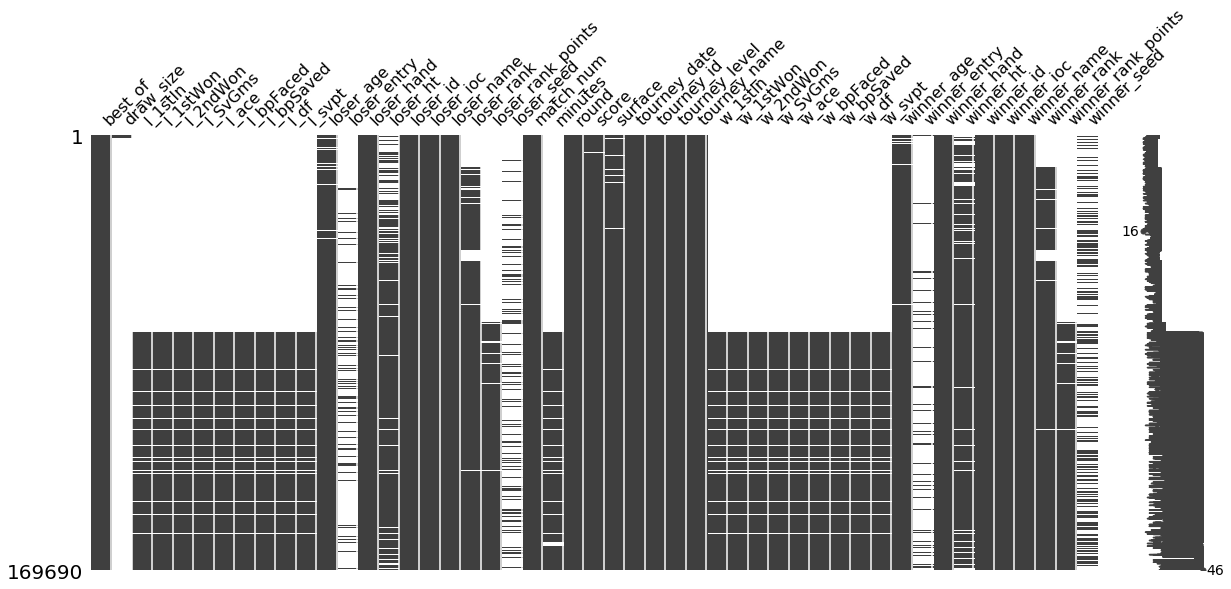

In [21]:
# Une visualisation qui permets de voir l'ampleur des missing values
missingno.matrix(data, figsize = (20,8))

In [22]:
# Alternative on va voir le nombre de missing values
data.isnull().sum()

best_of                    0
draw_size             168458
l_1stIn                86275
l_1stWon               86275
l_2ndWon               86275
l_SvGms                86275
l_ace                  86275
l_bpFaced              86275
l_bpSaved              86275
l_df                   86275
l_svpt                 86275
loser_age               4990
loser_entry           144351
loser_hand                85
loser_ht               30638
loser_id                   0
loser_ioc                  0
loser_name                 0
loser_rank             23781
loser_rank_points      76665
loser_seed            136837
match_num                  0
minutes                87587
round                      0
score                    176
surface                 2539
tourney_date               0
tourney_id                 0
tourney_level              0
tourney_name               0
w_1stIn                86275
w_1stWon               86275
w_2ndWon               86275
w_SvGms                86275
w_ace         

On remarque qu'il y a 3 grandes catégories de variables: Description du tourney, Description du Looser et Description du Winner.
C'est des données labelisés implicitement, donc une des taches serait d'extraire les labels Y à partir des données tout essayant de balancer les classes en créant Player 1 et Player 2 et en inversant afin d'avoir autant de 1 (pour Winner) que de 0 (pour Looser).

In [23]:
# Le choix se fera d'une maniere aleatoire afin d'eviter des biais
_data = data.copy()
data_winner = _data.sample(frac=0.5, random_state=23)
data_loser = _data.drop(data_winner.index)

In [24]:
# Je vais devoir inverser toutes les colonnes loser avec les colones winner sans toucher aux colonnes propres au tournoi(possible de le faire avec une RegEx sur le nom de la colonne mais ca risquerait de prendre trop de temps)
data_winner.rename(columns={"l_1stIn" : "w_1stIn", "l_1stWon" : "w_1stWon", "l_2ndWon" : "w_2ndWon",
                            "l_SvGms" : "w_SvGms", "l_ace" : "w_ace", "l_bpFaced" : "w_bpFaced",
                            "l_bpSaved" : "w_bpSaved", "l_df" : "w_df", "l_svpt" : "w_svpt",
                            "loser_age" : "winner_age", "loser_entry" : "winner_entry",
                            "loser_hand" : "winner_hand", "loser_ht" : "winner_ht",
                            "loser_id" : "winner_id", "loser_ioc" : "winner_ioc",
                            "loser_rank" : "winner_rank", "loser_rank_points" : "winner_rank_points",
                            "loser_seed" : "winner_seed",
                            "w_1stIn" : "l_1stIn",  "w_1stWon" : "l_1stWon", "w_2ndWon" : "l_2ndWon",
                            "w_SvGms" : "l_SvGms", "w_ace" : "l_ace", "w_bpFaced" : "l_bpFaced",
                            "w_bpSaved" : "l_bpSaved", "w_df" : "l_df", "w_svpt" : "l_svpt",
                            "winner_age" : "loser_age", "winner_entry" : "loser_entry",
                            "winner_hand" : "loser_hand", "winner_ht" : "loser_ht",
                            "winner_id" : "loser_id", "winner_ioc" : "loser_ioc",
                            "winner_rank" : "loser_rank", "winner_rank_points" : "loser_rank_points",
                            "winner_seed" : "loser_seed", }, inplace=True)

In [25]:
# Maintenant on ajoute la colonne Y du label 0: Loser / 1: Winner
data_loser['Y'] = 0
data_winner['Y'] = 1

In [26]:
# Rassembler les deux dataframe en un afin de nettoyer les datas puis creer les X et Y pour train et test
_data = data_loser.append(data_winner, sort=True)
_data.head()

,Y,best_of,draw_size,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,...,winner_age,winner_entry,winner_hand,winner_ht,winner_id,winner_ioc,winner_name,winner_rank,winner_rank_points,winner_seed
0,0,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,R,NaN,110023,AUS,Richard Coulthard,NaN,NaN,NaN
2,0,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.216290,NaN,R,NaN,100257,AUS,Ross Case,NaN,NaN,NaN
4,0,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.861739,NaN,R,NaN,109966,AUS,Warren Jacques,NaN,NaN,NaN
7,0,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.529774,NaN,R,173.0,100025,AUS,Barry Phillips Moore,NaN,NaN,3.0
11,0,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.702259,NaN,R,NaN,100180,AUS,Bill Lloyd,NaN,NaN,NaN


In [27]:
_data.winner_ioc.value_counts()

USA    33735
ESP    13384
AUS    12619
FRA    11054
GER     8774
       ...  
COK        2
AZE        1
BUR        1
RHO        1
PNG        1
Name: winner_ioc, Length: 134, dtype: int64

Il est possible d'utiliser geopandas pour visualiser la distribution des winners/losers par rapport à leurs pays.
Il serait interessant de l'exploiter car il y a des pays qui sont leader pour une discipline sportive donc ce qui permettrait d'aider à choisir le bon candidat.

In [28]:
_data.columns

Index(['Y', 'best_of', 'draw_size', 'l_1stIn', 'l_1stWon', 'l_2ndWon',
       'l_SvGms', 'l_ace', 'l_bpFaced', 'l_bpSaved', 'l_df', 'l_svpt',
       'loser_age', 'loser_entry', 'loser_hand', 'loser_ht', 'loser_id',
       'loser_ioc', 'loser_name', 'loser_rank', 'loser_rank_points',
       'loser_seed', 'match_num', 'minutes', 'round', 'score', 'surface',
       'tourney_date', 'tourney_id', 'tourney_level', 'tourney_name',
       'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_ace', 'w_bpFaced',
       'w_bpSaved', 'w_df', 'w_svpt', 'winner_age', 'winner_entry',
       'winner_hand', 'winner_ht', 'winner_id', 'winner_ioc', 'winner_name',
       'winner_rank', 'winner_rank_points', 'winner_seed'],
      dtype='object')

Je pars du principe que certains tournois ont toujours le meme type de surface; donc je vais creer un dictionnaire avec le nom des tournois pour clé et surface pour valeur afin d'essayer de minimiser les missing values

In [29]:
tournoi_surface = pd.Series(_data.surface.values, index=_data.tourney_name).to_dict()

old_missing_val = _data.surface.isna().sum()

_data['surface'] = _data.apply(lambda row: tournoi_surface[row['tourney_name']] if True else print('Next'), axis=1)

new_missing_val = _data.surface.isna().sum()

print("On a réduit les na de la colonne Surface de {} à {} valeurs".format(old_missing_val, new_missing_val))

On a réduit les na de la colonne Surface de 2539 à 2319 valeurs


In [30]:
_data['year'] = _data['tourney_date'].apply(lambda row: str(row)[:4])
_data['month'] = _data['tourney_date'].apply(lambda row: str(row)[4:6])

In [31]:
# Le choix des variables est fait de sorte à ne garder que les données qu'on peut facilement trouver avant 
# le match donc la description du winner/loser, leurs historiques et les caracteristiques du terrain
# et l'année car je suppose qu'il y a des tendances qui changent au fil des années

supprime = ['best_of','tourney_id', 'tourney_name', 'score', 'draw_size', 'winner_name', 'winner_seed',
            'winner_entry','loser_name', 'loser_seed','loser_entry','match_num', 'minutes', 'round',
            'tourney_date']
_data.drop(supprime,axis=1,inplace=True)

In [32]:
_data.head()

,Y,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,l_svpt,...,w_svpt,winner_age,winner_hand,winner_ht,winner_id,winner_ioc,winner_rank,winner_rank_points,year,month
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,R,NaN,110023,AUS,NaN,NaN,1968,01
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,16.216290,R,NaN,100257,AUS,NaN,NaN,1968,01
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,29.861739,R,NaN,109966,AUS,NaN,NaN,1968,01
7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,30.529774,R,173.0,100025,AUS,NaN,NaN,1968,01
11,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.702259,R,NaN,100180,AUS,NaN,NaN,1968,01


In [33]:
l_hand = _data.loser_hand.value_counts(normalize=True)[:-1]
l_hand

R    0.843957
L    0.139369
Name: loser_hand, dtype: float64

In [34]:
w_hand = _data.winner_hand.value_counts(normalize=True)[:-1]
w_hand

R    0.842480
L    0.140313
Name: winner_hand, dtype: float64

In [35]:
# On a pres de 85% des joueurs droitiers donc on va remplir les missing values en respectant la meme distribution

l_missing = _data['loser_hand'].isnull()
_data.loc[l_missing, 'loser_hand'] = pd.np.random.choice(l_hand.index, size=len(_data[l_missing]), p=l_hand.values/l_hand.values.sum())

In [36]:
w_missing = _data['winner_hand'].isnull()
_data.loc[w_missing, 'winner_hand'] = pd.np.random.choice(w_hand.index, size=len(_data[w_missing]), p=w_hand.values/w_hand.values.sum())

In [37]:
# Certaines colonnes caracterisant les joueurs comprennant des missing values vont etre rempli par la valeur moyenne 
# (car mediane prend nan :s)
median = ["l_1stIn", "w_1stIn", "l_1stWon", "w_1stWon", "l_2ndWon", "w_2ndWon",
          "l_SvGms", "w_SvGms", "l_bpSaved", "w_bpSaved", "l_bpFaced", "w_bpFaced", "l_ace", 
          "w_ace", "l_df", "w_df", "l_svpt", "w_svpt", "loser_age", "winner_age", "loser_ht",
          "winner_ht", "loser_rank", "winner_rank", "loser_rank_points", "winner_rank_points"]

for col in median:
    _data[col] = _data[col].fillna(pd.np.mean(_data[col]))

In [38]:
_data.head()

,Y,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,l_svpt,...,w_svpt,winner_age,winner_hand,winner_ht,winner_id,winner_ioc,winner_rank,winner_rank_points,year,month
0,0,47.482599,33.648684,15.920302,12.259126,5.619853,6.970677,4.170449,3.131691,79.302583,...,79.322208,25.637707,R,184.175453,110023,AUS,101.022926,1089.098918,1968,01
2,0,47.482599,33.648684,15.920302,12.259126,5.619853,6.970677,4.170449,3.131691,79.302583,...,79.322208,16.216290,R,184.175453,100257,AUS,101.022926,1089.098918,1968,01
4,0,47.482599,33.648684,15.920302,12.259126,5.619853,6.970677,4.170449,3.131691,79.302583,...,79.322208,29.861739,R,184.175453,109966,AUS,101.022926,1089.098918,1968,01
7,0,47.482599,33.648684,15.920302,12.259126,5.619853,6.970677,4.170449,3.131691,79.302583,...,79.322208,30.529774,R,173.000000,100025,AUS,101.022926,1089.098918,1968,01
11,0,47.482599,33.648684,15.920302,12.259126,5.619853,6.970677,4.170449,3.131691,79.302583,...,79.322208,18.702259,R,184.175453,100180,AUS,101.022926,1089.098918,1968,01


In [39]:
# Vue que j'ai eu des problemes de memoire avec la methode d'imputation je vais remplir 'Surface' en respecant la distribution
surf = _data.surface.value_counts(normalize=True)[:-1]
surf

Hard      0.391752
Clay      0.383693
Carpet    0.122763
Grass     0.101164
Name: surface, dtype: float64

In [40]:
surf_missing = _data['surface'].isnull()
_data.loc[surf_missing, 'surface'] = pd.np.random.choice(surf.index, size=len(_data[surf_missing]), p=surf.values/surf.values.sum())

In [41]:
_data.head()

,Y,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,l_svpt,...,w_svpt,winner_age,winner_hand,winner_ht,winner_id,winner_ioc,winner_rank,winner_rank_points,year,month
0,0,47.482599,33.648684,15.920302,12.259126,5.619853,6.970677,4.170449,3.131691,79.302583,...,79.322208,25.637707,R,184.175453,110023,AUS,101.022926,1089.098918,1968,01
2,0,47.482599,33.648684,15.920302,12.259126,5.619853,6.970677,4.170449,3.131691,79.302583,...,79.322208,16.216290,R,184.175453,100257,AUS,101.022926,1089.098918,1968,01
4,0,47.482599,33.648684,15.920302,12.259126,5.619853,6.970677,4.170449,3.131691,79.302583,...,79.322208,29.861739,R,184.175453,109966,AUS,101.022926,1089.098918,1968,01
7,0,47.482599,33.648684,15.920302,12.259126,5.619853,6.970677,4.170449,3.131691,79.302583,...,79.322208,30.529774,R,173.000000,100025,AUS,101.022926,1089.098918,1968,01
11,0,47.482599,33.648684,15.920302,12.259126,5.619853,6.970677,4.170449,3.131691,79.302583,...,79.322208,18.702259,R,184.175453,100180,AUS,101.022926,1089.098918,1968,01


In [42]:
_data.isnull().sum()

Y                     0
l_1stIn               0
l_1stWon              0
l_2ndWon              0
l_SvGms               0
l_ace                 0
l_bpFaced             0
l_bpSaved             0
l_df                  0
l_svpt                0
loser_age             0
loser_hand            0
loser_ht              0
loser_id              0
loser_ioc             0
loser_rank            0
loser_rank_points     0
surface               0
tourney_level         0
w_1stIn               0
w_1stWon              0
w_2ndWon              0
w_SvGms               0
w_ace                 0
w_bpFaced             0
w_bpSaved             0
w_df                  0
w_svpt                0
winner_age            0
winner_hand           0
winner_ht             0
winner_id             0
winner_ioc            0
winner_rank           0
winner_rank_points    0
year                  0
month                 0
dtype: int64

Maintenant que toute les colonnes que j'ai selectionné sont presque propre et sans valeurs manquantes je vais enregistrer le dataframe en csv de peur que le kernel ne tombe et que je perdes toutes les infos

In [43]:
_data.to_csv('prepared.csv', index=False)

Maintenant on va faire du Label Encoding des données et puis faire quelques visualisations pour comprendre les distributions mais également voir s'il n'est pas possible de diminuer le nombre de variables

In [3]:
_data = pd.read_csv('prepared.csv')
_data.tail()

,Y,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,l_svpt,...,w_svpt,winner_age,winner_hand,winner_ht,winner_id,winner_ioc,winner_rank,winner_rank_points,year,month
169685,1,47.482599,33.648684,15.920302,12.259126,5.619853,6.970677,4.170449,3.131691,79.302583,...,79.322208,33.26,R,183.000000,100121,RSA,138.0,1089.098918,1979,11
169686,1,47.482599,33.648684,15.920302,12.259126,5.619853,6.970677,4.170449,3.131691,79.302583,...,79.322208,30.98,R,184.175453,100081,USA,53.0,1089.098918,1975,2
169687,1,53.000000,33.000000,23.000000,13.000000,2.000000,13.000000,10.000000,3.000000,93.000000,...,112.000000,24.18,R,190.000000,102998,USA,22.0,1265.000000,2001,8
169688,1,47.482599,33.648684,15.920302,12.259126,5.619853,6.970677,4.170449,3.131691,79.302583,...,79.322208,20.80,R,185.000000,100452,USA,40.0,1089.098918,1977,8
169689,1,37.000000,28.000000,13.000000,10.000000,10.000000,2.000000,1.000000,2.000000,57.000000,...,61.000000,32.02,R,180.000000,104655,URU,33.0,1370.000000,2018,1


In [4]:
encode_col = _data.select_dtypes(include=['object']).columns.tolist()
encode_col

['loser_hand',
 'loser_ioc',
 'surface',
 'tourney_level',
 'winner_hand',
 'winner_ioc']

In [5]:
le = preprocessing.LabelEncoder()
for col in encode_col:
    _data[col] = le.fit_transform(_data[col].astype(str))

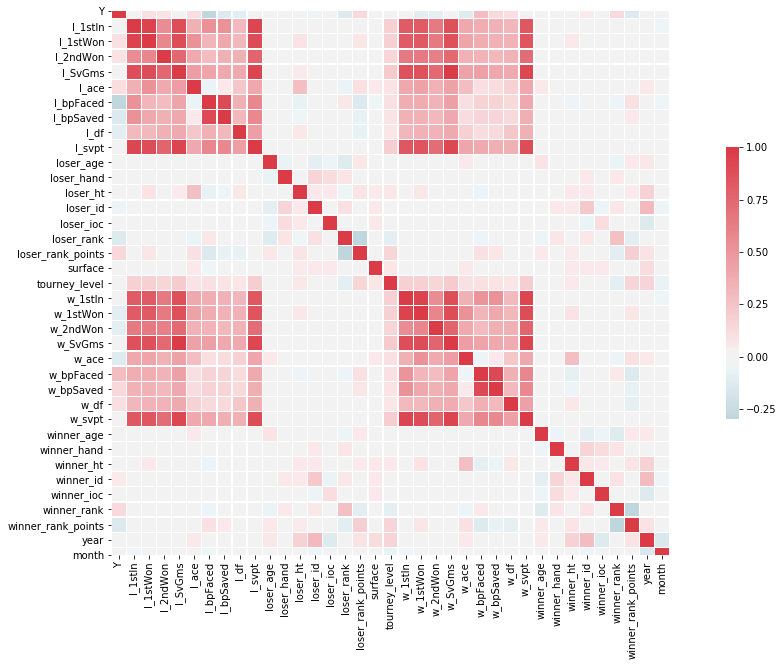

In [6]:
CorrMatrix = _data.corr()

f, ax = plt.subplots(figsize=(20,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(CorrMatrix, cmap=cmap, vmax=1, center=0, square=True, linewidth=.25, cbar_kws={"shrink": .5})

In [7]:
# Afin de verifier qu'il n'y ait pas une correlation assez grande d'une variable par rapport à notre Y
cor_target = abs(CorrMatrix["Y"])
relevant_features = cor_target[cor_target>0.5]
relevant_features

Y    1.0
Name: Y, dtype: float64

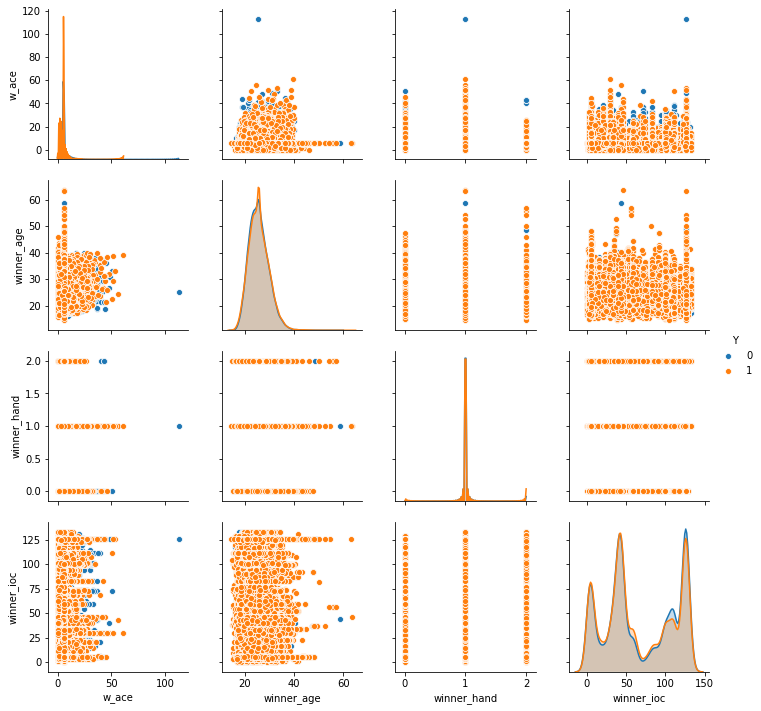

In [8]:
sns.pairplot(_data, hue='Y', vars=['w_ace', 'winner_age', 'winner_hand','winner_ioc'])

## Modélisation

In [9]:
# On commence deja par separer les X et les Y et puis splitter ces derniers en train et test sets 80/20
y = _data['Y']
X = _data.drop(['Y'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

Voila que les données sont pretes, il est temps de creer des modeles de classification binaire.
Je testerais la régression logistique, random forest, naive bayes, Gradient boosting et XG boost.
Je projettes également de creer un modele de Vote avec 5 algorithmes differents (nombre impaire pour éviter qu'ils soient à égalité de votes).
Une premiere fois serait sans optimisation des parametres et une seconde serait faites suite à un GridSearchCV.

# Version sans optimisation de parametres

In [10]:
lr = LogisticRegression(random_state=23)
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.7855501208085333

In [11]:
rf = RandomForestClassifier(random_state=3)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.7561140904001414

In [12]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_test_pred = gnb.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.6948847899110142

In [13]:
gbc = GradientBoostingClassifier(random_state=23)
gbc.fit(X_train, y_train)
y_test_pred = gbc.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.783340208615711

In [14]:
xgb = XGBClassifier(seed=23)
xgb.fit(X_train, y_train)
y_test_pred = xgb.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.7796864871235782

In [15]:
model = VotingClassifier([('LogReg',lr),('RanFor',rf),('GaussNB',gnb),('GradBoost',gbc),('XGBoost',xgb)], voting='hard')

In [16]:
model = model.fit(X_train,y_train)

In [17]:
y_test_pred = model.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.7886439978784843

# Version avec optimisation de parametres (GridSearchCV)

In [ ]:
params_lr = {"C":pd.np.logspace(-2,2,5), "penalty":["l1","l2"]}
lr_gs = GridSearchCV(lr, params_lr, cv=5)
lr_gs.fit(X_train, y_train)
y_test_pred = lr_gs.predict(X_test)
accuracy_score(y_test, y_test_pred)

In [ ]:
params_rf = {'n_estimators': [200, 500],'max_features': ['auto', 'sqrt', 'log2'],
             'max_depth' : [4,5,6,7,8], 'criterion' :['gini', 'entropy']}
rf_gs = GridSearchCV(rf, params_rf, cv=5)
rf_gs.fit(X_train, y_train)
y_test_pred = rf_gs.predict(X_test)
accuracy_score(y_test, y_test_pred)

In [ ]:
params_gbc = {"learning_rate": [0.01, 0.05, 0.075, 0.1], "n_estimators":[10]}
gbc_gs = GridSearchCV(gbc, params_gbc, cv=5)
gbc_gs.fit(X_train, y_train)
y_test_pred = gbc_gs.predict(X_test)
accuracy_score(y_test, y_test_pred)

In [ ]:
params_xgb = {'min_child_weight': [1, 5, 10],'gamma': [0.5, 1, 1.5, 2, 5],'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],'max_depth': [3, 4, 5]}
xgb_gs = GridSearchCV(xgb, params_xgb, cv=5)
xgb_gs.fit(X_train, y_train)
y_test_pred = xgb_gs.predict(X_test)
accuracy_score(y_test, y_test_pred)

In [ ]:
model_gs = VotingClassifier([('LogReg',lr_gs),('RanFor',rf_gs),('GaussNB',gnb),
                             ('GradBoost',gbc_gs),('XGBoost',xgb_gs)], voting='hard')

In [ ]:
model_gs = model_gs.fit(X_train,y_train)

In [ ]:
y_test_pred = model_gs.predict(X_test)
accuracy_score(y_test, y_test_pred)